In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
import fastNLP
from fastNLP.io.dataset_loader import CSVLoader
from fastNLP import Batch
from fastNLP import Vocabulary
from fastNLP import SequentialSampler

## Part1. Text classification using RNN with random word embedding
### 1. data_preprocess

In [2]:
def get_word(x):
    if(x == ' '):
        return [' ']
    else:
        return x.lower().split()

def load_data(path, is_train = 0):
    loader = CSVLoader(sep='\t')
    dataset = loader.load(path)
    dataset.delete_field('SentenceId')
    dataset.delete_field('PhraseId')
    
    dataset.apply(lambda x: get_word(x['Phrase']), new_field_name = 'words', is_input = True)
    dataset.apply(lambda x: len(x['words']), new_field_name = "length", is_input = True)
    dataset.delete_field('Phrase')
    if(is_train):
        dataset.apply(lambda x: int(x['Sentiment']), new_field_name = "Sentiment")
        dataset.set_target('Sentiment')
    return dataset

In [3]:
train_dataset = load_data('data/train.tsv', 1)
test_dataset = load_data('data/test.tsv', 0)
print("train_set size: ", train_dataset.get_length())
print("test_set size: ", test_dataset.get_length())

train_set size:  156060
test_set size:  66292


In [4]:
vocab = Vocabulary(min_freq=2).from_dataset(train_dataset, field_name='words')
vocab.index_dataset(train_dataset, field_name='words',new_field_name='words')
vocab.index_dataset(test_dataset, field_name='words',new_field_name='words')

In [7]:
# fastNLP真香，Batch可以自动padding
for batch_x, batch_y in Batch(train_dataset, sampler=SequentialSampler(), batch_size=16):
    print("batch_x:", batch_x['words'].size())
    print("batch_y:", batch_y)
    break

batch_x: torch.Size([16, 37])
batch_y: {'Sentiment': tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}


In [2]:
def load_data(file, is_train):
    csv_reader = csv.reader(open(file, newline=''), delimiter='\t')
    raw_data = list(csv_reader)[1:]
    text = [line[2].lower().split(' ') for line in raw_data]
    if(is_train):
        label = np.array([line[3] for line in raw_data], dtype = np.int32)
        return text, label
    else:
        return text

dev_size = 1000
train_text, train_label = get_data('data/train.tsv', 1)
print("whole dataset:", len(train_text))

validate_text = train_text[0:dev_size]
validate_label = train_label[0:dev_size]
train_text = train_text[dev_size:]
train_label = train_label[dev_size:]
test_text = get_data('data/test.tsv', 0)

print("train_text length:", len(train_text)) # list of list of words
print("train_label shape:", train_label.shape) # (N,)
print("validate_text length:", len(validate_text)) # list of list of words
print("validate_label shape:", validate_label.shape) # (N,)
print("test_text length:", len(test_text)) # list of words

whole dataset: 156060
train_text length: 155060
train_label shape: (155060,)
validate_text length: 1000
validate_label shape: (1000,)
test_text length: 66292


In [3]:
def get_vocabulary(text, min_count = 0):
    # 返回的vocabulary是dictionary类
    N = len(text)
    vocabulary = {}
    frequency = {}
    for i in range(N):
        for j in range(len(text[i])):
            if(text[i][j] in frequency.keys()):
                frequency[text[i][j]] += 1
            else:
                frequency[text[i][j]] = 1

    # check frequency
    count = 2
    vocabulary["<pad>"] = 0
    vocabulary["<unknown>"] = 1
    for key, value in frequency.items():
        if(value >= min_count):
            vocabulary[key] = count
            count += 1
    return vocabulary

train_voca = get_vocabulary(train_text)
print(len(train_voca))

16534


### 2. Hyperparameter

In [4]:
is_shuffle = True
batch_size = 16
embedding_size = 100
hidden_size = 64
load_address = None

use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda:  True


### 3. Capsulate data

In [5]:
class dataset(Dataset):
    def __init__(self, vocabulary, text, label = None):
    # text: [[words]] of length N
    # label: numpy array [N,]
        self.encoded_data = []
        for i, sentence in enumerate(text):
            word_index = []
            for word in sentence:
                if word in vocabulary.keys():
                    word_index.append(vocabulary[word])
                else:# unknown word
                    word_index.append(1)
            if label is None:
                target = -1
            else:
                target = label[i]
            self.encoded_data.append((word_index, len(word_index), target)) # tuple of (list, scalar, scalar)
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, index):
        return torch.LongTensor(self.encoded_data[index][0]), self.encoded_data[index][1], self.encoded_data[index][2]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: -x[1]) # 降序排序
    sentences, lengths, labels = zip(*batch) # 配对
    padded_sentences = pad_sequence(list(sentences), batch_first = True)
    return padded_sentences.to(device), torch.LongTensor(lengths).to(device), torch.LongTensor(labels).to(device)

In [6]:
train_dataset = dataset(train_voca, train_text, train_label)
train_dataloader = DataLoader(train_dataset,         
                              batch_size = batch_size,
                              collate_fn = collate_fn,
                              shuffle = True) 

validate_dataset = dataset(train_voca, validate_text, validate_label)
validate_dataloader = DataLoader(validate_dataset,         
                              batch_size = batch_size,
                              collate_fn = collate_fn,
                              shuffle = True) 

test_dataset = dataset(train_voca, test_text)
test_dataloader = DataLoader(test_dataset,         
                              batch_size = batch_size, 
                              collate_fn = collate_fn,
                              shuffle=False) 

### 4. Build RNN model

In [7]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.embedding = nn.Embedding(len(train_voca), embedding_size)# nn.Embedding用的是N(0,1)的随机初始化
        self.LSTM = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Linear(16, 5)
        )

    def forward(self, x, lengths):
        N = x.shape[0]
        h0 = Variable(torch.zeros(1, N, hidden_size)).to(device)
        c0 = Variable(torch.zeros(1, N, hidden_size)).to(device)
        x = self.embedding(x)
        x = pack_padded_sequence(x, lengths, batch_first=True) # 去掉所有padding, [N, T, E] -> [N * T, E]
        x, (ht, ct) = self.LSTM(x, (h0, c0))
        score = self.classifier(ht.view(N, -1))
        return score
    
model = RNN()
model = model.to(device)
if(load_address is not None):
    model = torch.load(load_address)

### 5. Train Model

In [8]:
def predict(model, dataloader):
    num_correct = torch.tensor(0.0)
    num_sample = torch.tensor(0.0)
    for index,(x, lengths, y) in enumerate(dataloader):
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1)
        num_correct += torch.sum(y_predict == y)
        num_sample += x.shape[0]
    return 1.0 * num_correct / num_sample

In [9]:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)

In [10]:
def train(model, dataloader, optimizer, num_epoch = 30):
    loss_history = []
    for i in range(num_epoch):
        losses = 0
        for index,(x, lengths, y) in enumerate(dataloader):
            optimizer.zero_grad()
            score = model(x, lengths)
            loss_fn = nn.CrossEntropyLoss().to(device)
            loss = loss_fn(score, y)
            loss.backward()
            losses += loss
            optimizer.step()
        loss_history.append(losses)
        print("Epoch: {0}, loss: {1}, accu: {2}".format(i, losses, predict(model, validate_dataloader)))
        if((i + 1) % 50 == 0):
            torch.save(model, "RNN random embedding_batch {0}_embedding {1}_epoch {2}".format(batch_size, embedding_size, i + 1))
    return loss_history

loss_history = train(model, train_dataloader, optimizer, num_epoch = 3)

Epoch: 0, loss: 11176.71875, accu: 0.5929999947547913
Epoch: 1, loss: 9843.796875, accu: 0.628000020980835
Epoch: 2, loss: 9190.310546875, accu: 0.6359999775886536


### 6. Get Result

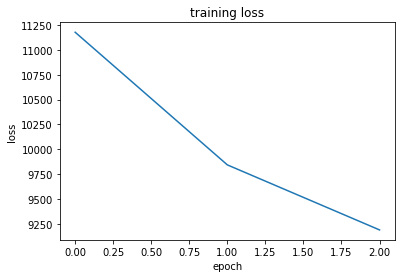

In [11]:
def plot(plt):
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.plot(range(len(loss_history)), loss_history)
    return plt

plt.figure(0)
plot(plt)
plt.show()

In [168]:
def get_answer(model, dataloader):
    answer = []
    for index,(x,lengths, y) in enumerate(dataloader):
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1).cpu().numpy()
        answer += list(y_predict)
    index = [a + 156061 for a in range(len(answer))]
    dataframe = pd.DataFrame({'PhraseId':index, 'Sentiment':answer})
    dataframe.to_csv("answer_RNN.csv",index=False,sep=',')
    return answer

answer = get_answer(model, test_dataloader)